#### Import modules & prepare data

In [48]:
# Import sklearn/tensorflow modules.
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import other modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from os import walk
from time import sleep
from IPython.display import clear_output
%matplotlib inline

# Data source: https://www.kaggle.com/stephenmugisha/particle-collisions

_, _, files = next(walk('data'))

target_names = {
    '0': 'electron',    # Negatively charged particle that is a lepton  (doesn't take part in strong force).
    '1': 'muon',    # Electron with 200 times more mass and makes up lots of cosmic radiation.
    '2': 'pion',    # Meson (connects with strong force) that can be positive, negative, or neutral
    '3': 'kaon',    # Pion with more mass.
    '4': 'proton'    # Positively charged particle with 2 up quarks and 1 down quark.
}

# Check how the data is formatted/stored.
file_test = open(f'data/{files[0]}', 'rb')
file = pickle.load(file_test)

print(file[0].shape)    # Group of 3000 images.
print(file[0][0].shape)    # Check first image.
print(file[1].shape)    # Group of 3000 targets.
print(file[1][0])    # Classified as 'pion.'

# Collect all the data.
data = []
target = []

for file in files:
    file = open(f'data/{files[0]}', 'rb')
    file =  pickle.load(file)

    for sample, sample_target in zip(file[0], file[1]):
        data.append(sample)
        target.append(sample_target)

data = np.array(data)
target = np.array(target)

sleep(7)
clear_output()

print(f'original data.shape: {data.shape}')
print(f'original target.shape: {target.shape}\n')

# Edit target values to 0, 1, 2...
new_target = []

for tar in target:
    if tar == 11:
        new_target.append(0)
    elif tar == 13:
        new_target.append(1)
    elif tar == 211:
        new_target.append(2)
    elif tar == 321:
        new_target.append(3)
    else:
        new_target.append(4)
    
target = np.array(new_target)

for i in range(5):
    particle_indexes = np.where(target == i)[0]

    data_modified = data[particle_indexes]
    target_modified = target[particle_indexes]
    
    print(f'{target_names[str(i)]}.shape: {data_modified.shape}, {target_modified.shape}')

# NOTE: through the above code, we find there are inconsistencies in the data (less samples for one particle but lots of samples in another)


original data.shape: (1259300, 10, 10)
original target.shape: (1259300,)

electron.shape: (3150, 10, 10), (3150,)
muon.shape: (700, 10, 10), (700,)
pion.shape: (981050, 10, 10), (981050,)
kaon.shape: (160300, 10, 10), (160300,)
proton.shape: (114100, 10, 10), (114100,)


#### Reshaping data (to make even)

In [49]:
muon_indexes = np.where(target == 1)[0]    # since this has least # of samples... use this as limiter

def set_data_samples(number_of_samples):    # limit to <= 700 samples for each particle. (to keep data even)
    
    data_new, target_new = ((data[muon_indexes])[:number_of_samples], (target[muon_indexes])[:number_of_samples])
    
    for i in [0, 2, 3, 4]:
        particle_indexes = np.where(target == i)[0]
        data_modified = (data[particle_indexes])[:number_of_samples]    
        target_modified = (target[particle_indexes])[:number_of_samples]
    
        data_new = np.append(data_new, data_modified, axis=0)
        target_new = np.append(target_new, target_modified)

    return (np.array(data_new), np.array(target_new))


data_140_samples, target_140_samples = set_data_samples(140)    # NOTE: These will be used for later tests.
data_280_samples, target_280_samples = set_data_samples(280)
data_420_samples, target_420_samples = set_data_samples(420)
data_560_samples, target_560_samples = set_data_samples(560)
data_700_samples, target_700_samples = set_data_samples(700)

data = data_700_samples    # Regular number of samples that should be used.
target = target_700_samples

print(f'even data.shape: {data.shape}')
print(f'even target.shape: {target.shape}')


even data.shape: (3500, 10, 10)
even target.shape: (3500,)


#### Data analysis

X_train.shape: (2625, 10, 10, 1)
y_train.shape: (2625, 5)
X_test.shape: (875, 10, 10, 1)
y_test.shape: (875, 5)


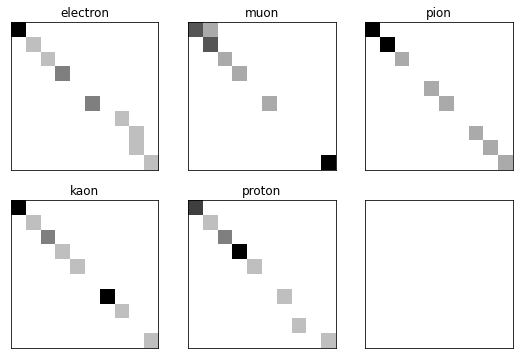

In [50]:
# Check for NaN values.
print(np.isnan(np.sum(data)))    # -> False

# Check range of values.
print(np.max(data), np.min(data))    # -> 8, 0

sleep(4)
clear_output()

# Get indexes for each different target possibility.
indexes = [
    np.where(target == 0)[0][0],
    np.where(target == 1)[0][0],
    np.where(target == 2)[0][0],
    np.where(target == 3)[0][0],
    np.where(target == 4)[0][0],
]

samples = [data[index] for index in indexes]
samples_target = [target_names[str(target[index])] for index in indexes]

fig, axs = plt.subplots(2, 3, figsize=(9, 6), subplot_kw={
    'yticks': (),
    'xticks': ()
})

axs = [ax for ax in axs.flatten()]

for sample, sample_target, ax in zip(samples, samples_target, axs):
    ax.imshow(sample, cmap='binary')
    ax.set_title(str(sample_target))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target)

# Change the train and test datasets.
scaler = StandardScaler()

# Reshape + change data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Scale and reshape data back to og form.
X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')


#### Create Model

Train accuracy: 37.6%
Test accuracy: 35.7%


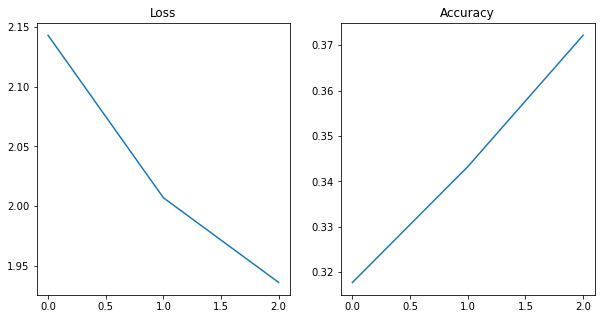

In [51]:
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()

        self.input_layers = [
            MaxPooling2D((2, 2)),
            Flatten()
        ]

        self.hidden_layers = [
            Dense(19, activation='relu', kernel_regularizer='l2'),
            Dense(19, activation='relu', kernel_regularizer='l2')
        ]

        self.output_layer = Dense(5, activation='softmax')
    
    def call(self, inputs):
        h = self.input_layers[0](inputs)
        h = self.input_layers[1](h)

        for hidden_layer in self.hidden_layers:
            h = hidden_layer(h)
        
        return self.output_layer(h)

model = Model()

model.build(input_shape=(1, 10, 10, 1))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=3, batch_size=64).history

sleep(4)
clear_output()

print(f'Train accuracy: {model.evaluate(X_train, y_train, verbose=False)[1]*100:.1f}%')
print(f'Test accuracy: {model.evaluate(X_test, y_test, verbose=False)[1]*100:.1f}%')

fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(10, 5))

ax_1.plot(range(3), history['loss'])
ax_2.plot(range(3), history['accuracy'])

ax_1.set_title('Loss')
ax_2.set_title('Accuracy');


### More data analysis

In [52]:
for i in range(5):
    int_y_test = np.array([np.argmax(y, axis=None, out=None) for y in y_test])    # convert back to integer for comparison.
    particle_indexes = np.where(int_y_test == i)    # gives indexes for all electron, muon, etc testcases...

    X_test_modified = X_test[particle_indexes]
    y_test_modified = y_test[particle_indexes]

    print(f'{target_names[str(i)]} accuracy: {model.evaluate(X_test_modified, y_test_modified, verbose=False)[1]*100:.1f}%')


electron accuracy: 50.9%
muon accuracy: 49.1%
pion accuracy: 16.6%
kaon accuracy: 50.3%
proton accuracy: 11.4%


#### Test Results
<img src='images/test_1_(19).png'>
<img src='images/test 2 (19).png'></br>
difference between one test and another (inconsistencies)

#### Conclusion:
* The algorithm shows some promise for some particles, but little for others.
    * muon could have 100% accuracy because of its mass... has less quantum effect compared to others.
    * electron could be low because of quantum effects
    * proton is actually pretty consistent.
    * out of mesons, kaon and proton lowest while pion higher (because of higher mass than other mesons)
    * next steps, find reason for fluctuations in percentages and relationships between particles considering their properties.

#### Graph relationship between sample size and accuracy

In [63]:
sample_numbers = [140, 280, 420, 560, 700]    # This will be the x
accuracy = []

for sample_number, data_x_samples in zip(sample_numbers, [(data_140_samples, target_140_samples), (data_280_samples, target_280_samples), (data_420_samples, target_420_samples), (data_560_samples, target_560_samples), (data_700_samples, target_700_samples)]):
    X_train, X_test, y_train, y_test = train_test_split(data_x_samples[0], data_x_samples[1], stratify=data_x_samples[1])

    scaler = StandardScaler()

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    X_train = (scaler.fit_transform(X_train)).reshape((X_train.shape[0], 10, 10, 1))
    X_test = (scaler.transform(X_test)).reshape((X_test.shape[0], 10, 10, 1))
    
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    model.build(input_shape=(1, 10, 10, 1))
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=3, batch_size=64, verbose=False)
    
    print(f'Train accuracy: {model.evaluate(X_train, y_train, verbose=False)[1]*100:.1f}% ({sample_number} samples)')
    print(f'Test accuracy: {model.evaluate(X_test, y_test, verbose=False)[1]*100:.1f}% ({sample_number} samples)')
    
    # result = model.evaluate(data_modified_scaled, target_modified_scaled, verbose=False)[1]*100
    # accuracy.append(result)

# # Plot results.
# plt.plot(sample_numbers, accuracy)
# plt.title('Accuracy by Sample Size')
# plt.xlabel('sample #')
# plt.ylabel('accuracy %')


Train accuracy: 51.4% (140 samples)
Test accuracy: 49.7% (140 samples)
Train accuracy: 50.3% (280 samples)
Test accuracy: 46.3% (280 samples)
Train accuracy: 49.1% (420 samples)
Test accuracy: 51.8% (420 samples)
Train accuracy: 49.4% (560 samples)
Test accuracy: 51.0% (560 samples)
Train accuracy: 49.1% (700 samples)
Test accuracy: 48.7% (700 samples)


#### 5 Test Runs (when trained on 700 samples):
<img src='images/accuracy_sample_test1.png'>
<img src='images/accuracy_sample_test2.png'>
<img src='images/accuracy_sample_test3.png'>
<img src='images/accuracy_sample_test4.png'>
<img src='images/accuracy_sample_test5.png'>